## 🧩 1. Import Libraries & Load Data

In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/princechaudhary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df=pd.read_csv('data.csv',encoding='latin1',header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns= ['target', 'id', 'date', 'flag', 'user', 'text']

In [6]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 📊 2. Understand Data Structure

In [7]:
# Basic info
df.info()

# Shape of dataset
print()
print("Dataset shape:", df.shape)

# Check for missing values
print()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

Dataset shape: (1600000, 6)



target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


## 🎯 3. Check Sentiment Distribution

/var/folders/8t/1xgb90cn3ns84sssmr9z_bf40000gn/T/ipykernel_27320/3288195280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


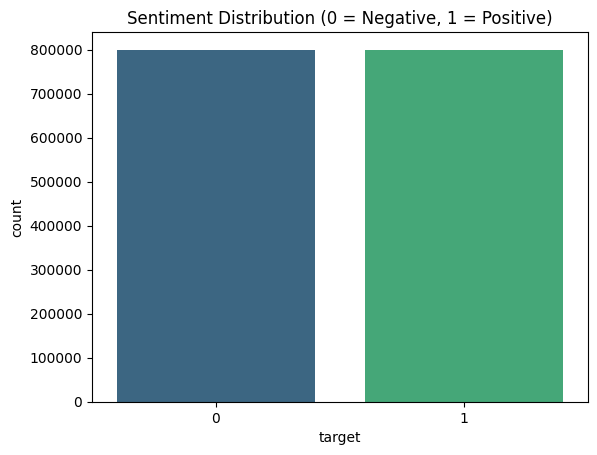

target
0    50.0
1    50.0
Name: proportion, dtype: float64


In [9]:
# Replace 4 → 1 for clarity (Positive)
df['target'] = df['target'].replace(4, 1)

# Visualize
sns.countplot(x='target', data=df, palette='viridis')
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.show()

# Percentage distribution
print(df['target'].value_counts(normalize=True) * 100)


In [10]:
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

## 💬 4. Sample Tweets per Class

In [11]:
for label in df['target'].unique():
    print(f"\nSample Tweets for Sentiment {label}:")
    print(df[df['target'] == label]['text'].sample(3).to_list())



Sample Tweets for Sentiment 0:
["@tplaysbass  Not yet!  I'm  not sure what happened.  It was syncing with my computer and I'm guessing it duplicated my office contacts. ", '@morningshowz103 awww mannnn i just filled up on gas right before i got homeee  lol', "@snugglezz http://bit.ly/hSK17  &lt;- couldn't find the korean version "]

Sample Tweets for Sentiment 1:
['@jonoread yay ! im not the only one then ', 'mass exodus in the office! ', 'obscura is godly. had a good time tonight. ']


## 🧹 5. Basic Text Cleaning

In [12]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#', '', text)        # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove special characters
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david car...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


In [13]:
df.head(2)

,target,id,date,flag,user,text,clean_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...


In [14]:
df['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [15]:
df['clean_text'][0]

'awww thats a bummer  you shoulda got david carr of third day to do it d'

## 🪶 6. Tweet Length & Word Count Analysis

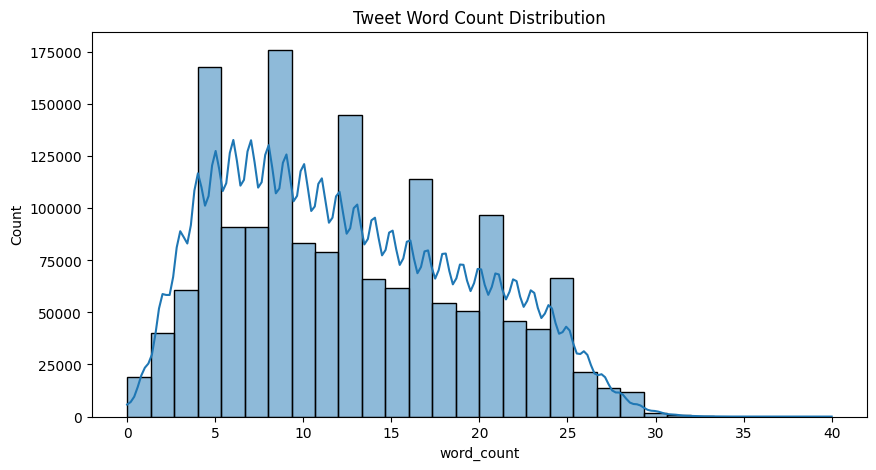

In [16]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(lambda x: len(x))

# Plot distributions
plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Tweet Word Count Distribution")
plt.show()


## ☁️ 7. WordCloud Visualization

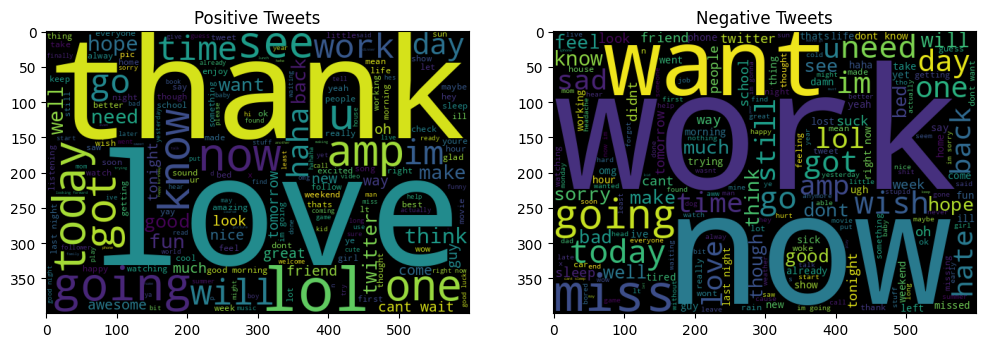

In [17]:
from wordcloud import WordCloud

# Positive Tweets
pos_text = ' '.join(df[df['target']==1]['clean_text'])
neg_text = ' '.join(df[df['target']==0]['clean_text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(pos_text))
plt.title("Positive Tweets")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(neg_text))
plt.title("Negative Tweets")

plt.show()


## 📈 8. Most Frequent Words (Positive vs Negative)

In [18]:
from collections import Counter

# Split and count words
pos_words = ' '.join(df[df['target']==1]['clean_text']).split()
neg_words = ' '.join(df[df['target']==0]['clean_text']).split()

pos_common = Counter(pos_words).most_common(20)
neg_common = Counter(neg_words).most_common(20)

# Convert to DataFrame for visualization
pd.DataFrame(pos_common, columns=['Word', 'Frequency']).head(10)


,Word,Frequency
0,i,288934
1,the,263868
2,to,251962
3,a,197066
4,you,176065
5,and,147273
6,my,125003
7,for,117026
8,it,111915
9,is,108413


# 🧠 Phase 2: Feature Engineering + Model Building + FastAPI Deployment

## ⚙️ 1. Data Preprocessing & Feature Engineering

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare features and labels
X = df['clean_text']
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## 🤖 2. Define and Train Models

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=5, random_state=42)
}

results = []

for model_name, model in models.items():
    print(f"🔹 Training {model_name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1
    })
    
    print(f"✅ {model_name} Accuracy: {acc:.4f}, F1: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


🔹 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.7956, F1: 0.7987
              precision    recall  f1-score   support

           0       0.81      0.78      0.79    160000
           1       0.79      0.81      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

------------------------------------------------------------
🔹 Training Naive Bayes...
✅ Naive Bayes Accuracy: 0.7733, F1: 0.7703
              precision    recall  f1-score   support

           0       0.77      0.79      0.78    160000
           1       0.78      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

------------------------------------------------------------
🔹 Training Support Vector Machine...
✅ Support Vector Machine Accuracy

## 📊 3. Compare Model Performance

In [21]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df


,Model,Accuracy,F1 Score
0,Logistic Regression,0.795569,0.798690
2,Support Vector Machine,0.795338,0.799115
1,Naive Bayes,0.773300,0.770323
3,Random Forest,0.753812,0.752818


## 4. Optional Visualization

/var/folders/8t/1xgb90cn3ns84sssmr9z_bf40000gn/T/ipykernel_27320/1800753358.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")


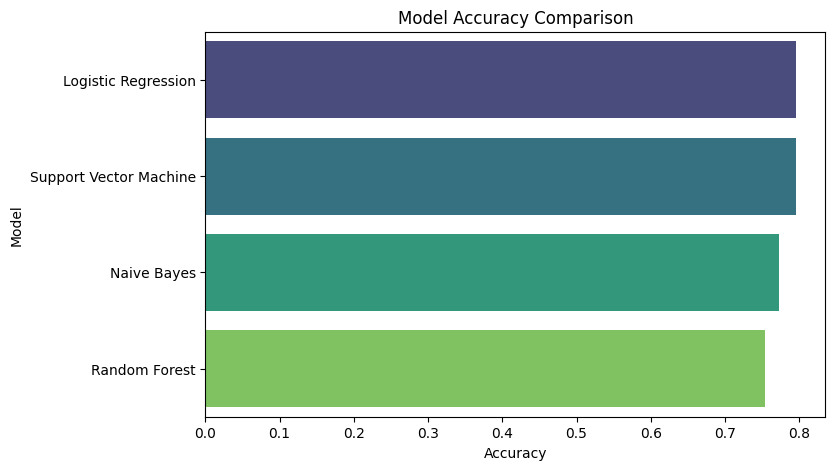

In [22]:
plt.figure(figsize=(8,5))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()


## 5: Visualize Confusion Matrix (Best Model)

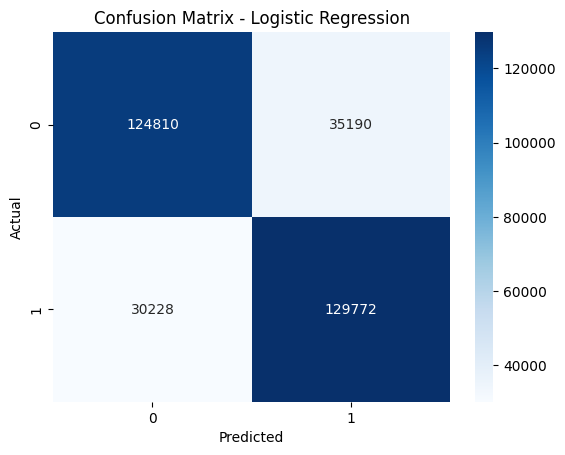

In [23]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Step 6: Save Best Model & Vectorizer

In [24]:
import joblib

joblib.dump(best_model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print(f"✅ Saved best model ({best_model_name}) and vectorizer.")


✅ Saved best model (Logistic Regression) and vectorizer.


##  | Category      | Example Models            | Accuracy Range | Complexity |
### | ------------- | ------------------------- | -------------- | ---------- |
### | Classical ML  | LR, NB, SVM, RF           | 80–88%         | Low        |
### | Deep Learning | LSTM, CNN, BiLSTM         | 85–90%         | Medium     |
### | Transformers  | BERT, DistilBERT, RoBERTa | 90–95%         | High       |
